In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/miniconda3/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/miniconda3/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
import sys
sys.path.insert(0, '../../')
from src.discoverers.adsorption.randomsearch_cfgp import RandomSearcherCFGP


# Initialize
discoverer = RandomSearcherCFGP(db_dir=db_dir,
                                target_energy=target_energy,
                                quantile_cutoff=quantile_cutoff,
                                batch_size=batch_size,
                                training_features=training_features,
                                training_labels=training_labels,
                                training_surfaces=training_surfaces,
                                sampling_features=sampling_features,
                                sampling_labels=sampling_labels,
                                sampling_surfaces=sampling_surfaces,
                                init_train=False  # Set to `False` only for warm starts
                                )

### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']


## Run

In [ ]:
discoverer.simulate_discovery()

In [5]:
# Or load the last run
discoverer.load_last_run()

wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Loading dataset: gasdb
### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']
### Loading model: cgcnn
### Loaded CGCNN with 189121 parameters.
cmd:
  checkpoint_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/random_cfgp/checkpoints/2020-06-22-17-25-06-cnn
  identifier: cnn
  logs_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/random_cfgp/logs/2020-06-22-17-25-06-cnn
  print_every: 100
  results_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/random_cfgp/results/2020-06-22-17-25-06-cnn
  seed: null
  timestamp: 2020-06-22-17-25-06-cnn
dataset:
  src: ../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: wandb
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  warmup_epochs: 10
  war

## Analyze

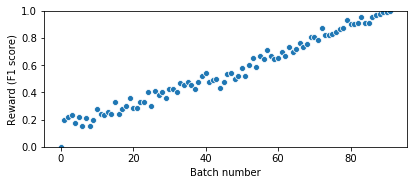

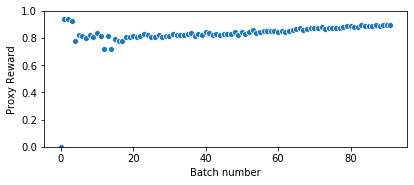

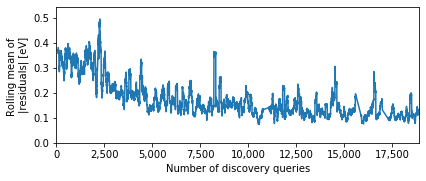

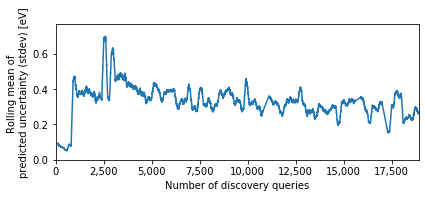

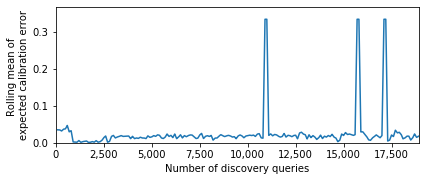

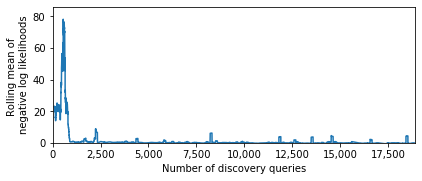

In [6]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)